# Efficient Frontier Using Optimization with Scipy

The goal of optimization is to find the best (optimal) value of the objective function by adjusting the target variables and taking into account some boundaries and
constraints (which have an impact on the target variables). In this case, the objective function is a function returning portfolio volatility, and the target variables are portfolio weights.

In [24]:
import numpy as np
import scipy.optimize as sco
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['META', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [26]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  4 of 4 completed
Downloaded 250 rows of data.


<AxesSubplot:title={'center':'Stock prices of the considered assets'}, xlabel='Date'>

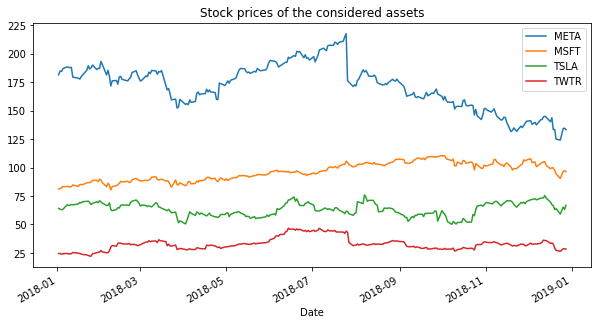

In [45]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets', figsize=(10,5))

In [28]:
# Calculate annualized average returns and the corresponding standard deviation

returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [29]:
# Simulate random portfolio weights

np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]


# Calculate portfolio metrics

portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [30]:
# Create joint dataframe with all the required data
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

# Locate the points creating the efficient frontier
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

In [31]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [32]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [33]:
# Define the considered range of returns

rtns_range = np.linspace(-0.22, 0.32, 200)

In [34]:
# Calculate the efficient FrozenImporter

efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

In [35]:
# Extract the volatilities of efficient frontier
vols_range = [x['fun'] for x in efficient_portfolios]

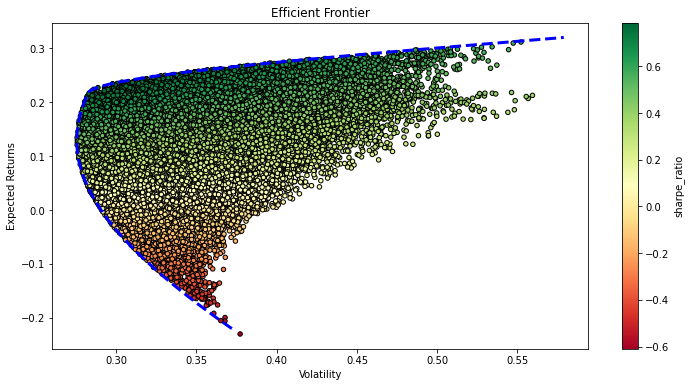

In [44]:
# Plot the calculated Efficient Frontier, together with the simulated portfolios

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

plt.rcParams["figure.figsize"] = (12,6)
plt.show()

In [37]:
# Identify the minimum volatility portfolio
  
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': 0.13005025125628142,
 'Volatility': 0.2754157286911326,
 'Sharpe Ratio': 0.4721961664075018}

In [38]:
# Print performance summary 

print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 13.01% Volatility: 27.54% Sharpe Ratio: 47.22% 
Weights
META: 18.65% MSFT: 77.34% TSLA: 4.01% TWTR: 0.00% 

We can also use the optimization approach to find the weights that generate a portfolio with the highest expected Sharpe ratio—the Tangency Portfolio. To do so, we first need to
define the objective function, which is the negative of the Sharpe ratio. The reason why we use the negative is that the optimization algorithms run minimization problems. We can
easily approach the maximization problems by changing the sign of the objective metric. 

In [39]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

In [40]:
# Find the optimized portfolio 
 
n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [41]:
# Extract information about the maximum Sharpe Ratio portfolio

max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': 0.23097189745365157,
 'Volatility': 0.2924977465015082,
 'Sharpe Ratio': 0.789653596365265}

In [42]:
# Print performance summary 

print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 23.10% Volatility: 29.25% Sharpe Ratio: 78.97% 
Weights
META: 0.00% MSFT: 81.50% TSLA: 2.79% TWTR: 15.72% 